In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

In [2]:
path_to_processed_train = '../data/processed/train/'
files = sorted(glob.glob(path_to_processed_train+'*'))
files[0]

df = pd.read_csv(files[0])

to_drop = ['unit_id', 'time_cycle', 'max_cycle']
constant_features = ['op_set_3', 'sensor_18', 'sensor_19']
quasi_cons_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16']
features = [x for x in df.columns if x not in constant_features+quasi_cons_features+to_drop]

In [3]:
df['max_cycle'].max()

362

In [4]:
y = df['RUL']
X = df[features[:-1]]

In [10]:
# split dataset & prepare 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline

# ML model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# DL model
from sklearn.neural_network import MLPRegressor

# metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# features scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(16504, 16) (4127, 16) (16504,) (4127,)


In [7]:
model = SVR(kernel='linear')
model.fit(X_train, y_train)

model.score(X_train,y_train) , model.score(X_test,y_test)

(0.5661444544316434, 0.5575576364089707)

In [8]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [9]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

model.score(X_train,y_train) , model.score(X_test,y_test)

(0.6211944524292272, 0.6116387533805021)

In [32]:
sgd = SGDRegressor(penalty='elasticnet')
sgd.fit(X_train,y_train)
sgd.score(X_train,y_train) , sgd.score(X_test,y_test)

(0.5808143610785266, 0.5730745863838305)

In [33]:
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'elasticnet',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_pred

array([152.5092918 ,  55.23020333, 133.87815799, ..., 157.02184247,
       111.65405797, 125.81944728])

In [16]:
y_test.reset_index(drop=True)

0       169
1       112
2       151
3        89
4        87
       ... 
4122     29
4123     32
4124    166
4125    143
4126     70
Name: RUL, Length: 4127, dtype: int64

In [17]:
model.coef_

AttributeError: coef_ is only available when using a linear kernel

In [18]:
type(y_test), type(pd.Series(y_pred))

(pandas.core.series.Series, pandas.core.series.Series)

In [27]:
# create RUL df to compute error,d and score,s
RUL = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=True )
RUL.rename(columns={0:'true', 1:'estimated'}, inplace=True)

# cast as int
RUL['estimated'] = [int(i) for i in RUL['estimated']]
 
# compute error d
RUL['error'] = RUL['estimated'] - RUL['true']

RUL

,true,estimated,error
0,169,152,-17
1,112,55,-57
2,151,133,-18
3,89,125,36
4,87,92,5
...,...,...,...
4122,29,32,3
4123,32,45,13
4124,166,157,-9
4125,143,111,-32


In [28]:
import math

RUL['score'] = 0

# compute score s
for i in range(len(RUL)):
    if RUL['error'][i] < 0 : 
        d = RUL['error'][i]
        RUL['score'][i] = math.exp(-d/13) - 1
    else :
        d = RUL['error'][i]
        RUL['score'][i] = math.exp(d/10) - 1

RUL

,true,estimated,error,score
0,169,152,-17,2
1,112,55,-57,79
2,151,133,-18,2
3,89,125,36,35
4,87,92,5,0
...,...,...,...,...
4122,29,32,3,0
4123,32,45,13,2
4124,166,157,-9,0
4125,143,111,-32,10


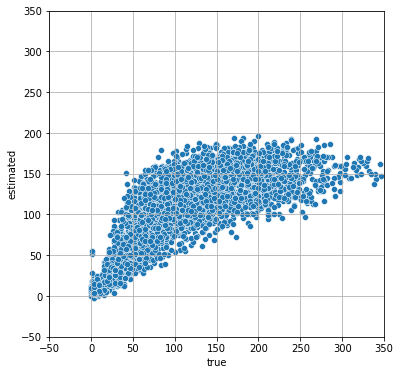

In [40]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=RUL, x='true', y='estimated')
plt.xlim(-50,350)
plt.ylim(-50,350)
plt.grid()
plt.show()

In [30]:
RUL['score'].max(), RUL['score'].min()

(4802346, 0)

<AxesSubplot:xlabel='error', ylabel='score'>

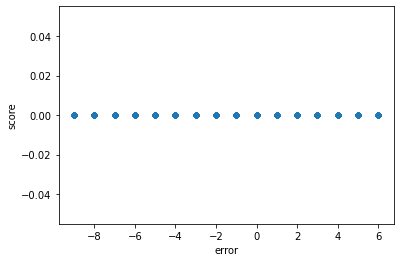

In [31]:
RUL[RUL['score'] == RUL['score'].min()].plot(kind='scatter', x='error', y='score')